# The First Stars: Formation under Cosmic Ray Feedback -- Phase Diagrams

This notebook generates all simulation results figures for my current paper.  All simulations run on stampede.tacc.utexas.edu

In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
#mpl.rc('font', size=20.)
#mpl.rc('font', family='serif')
mpl.rc('text', usetex=True)
import seaborn as sns
import pyGadget

/home/jhummel/anaconda/envs/upgrading/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
sns.set(context='poster', style='darkgrid', font='serif', font_scale=1.)

In [3]:
simname = {'vanilla':r'$u_{\rm \tiny CR} = 0$',
        'cr00': r'$u_{\rm \tiny CR} = u_0$', 
        'cr01': r'$u_{\rm \tiny CR} = 10 u_0$', 
        'cr02': r'$u_{\rm \tiny CR} = 10^2 u_0$', 
       'cr03': r'$u_{\rm \tiny CR} = 10^3 u_0$', 
        'cr04': r'$u_{\rm \tiny CR} = 10^4 u_0$',
        'cr05': r'$u_{\rm \tiny CR} = 10^5 u_0$'}
simlist = ['vanilla', 'cr00', 'cr01', 'cr02', 'cr03', 'cr04', 'cr05']

In [4]:
ars_temp = pd.read_csv(os.getenv("HOME")+'/data/literature_data/Stacy_Bromm2007/f2_nocr.csv', names=['n', 'temp'])
ars_temp_hiSF = pd.read_csv(os.getenv("HOME")+'/data/literature_data/Stacy_Bromm2007/f2_1e6_high.csv', names=['n', 'temp'])
ars_temp_loSF = pd.read_csv(os.getenv("HOME")+'/data/literature_data/Stacy_Bromm2007/f2_1e6_low.csv', names=['n', 'temp'])
ars_mbe = pd.read_csv(os.getenv("HOME")+'/data/literature_data/Stacy_Bromm2007/f6_nocr.csv', names=['n', 'Mbe'])
ars_mbe_hiSF = pd.read_csv(os.getenv("HOME")+'/data/literature_data/Stacy_Bromm2007/f6_1e6_high.csv', names=['n', 'Mbe'])
ars_mbe_loSF = pd.read_csv(os.getenv("HOME")+'/data/literature_data/Stacy_Bromm2007/f6_1e6_low.csv', names=['n', 'Mbe'])
for df in [ars_temp, ars_temp_hiSF, ars_temp_loSF]:
    df['logn'] = np.log10(df.n)
    df['logT'] = np.log10(df.temp)
for df in [ars_mbe, ars_mbe_hiSF, ars_mbe_loSF]:
    df['logn'] = np.log10(df.n)
    df['logM'] = np.log10(df.Mbe)   

In [5]:
sim = 'halo1'
simV = pyGadget.sim.Simulation('stampede/'+sim+'_vanilla',length='pc')
sim0 = pyGadget.sim.Simulation('stampede/'+sim+'_cr00',length='pc')
sim1 = pyGadget.sim.Simulation('stampede/'+sim+'_cr01',length='pc')
sim2 = pyGadget.sim.Simulation('stampede/'+sim+'_cr02',length='pc')
sim3 = pyGadget.sim.Simulation('stampede/'+sim+'_cr03',length='pc')
sim4 = pyGadget.sim.Simulation('stampede/'+sim+'_cr04',length='pc')
sim5 = pyGadget.sim.Simulation('stampede/'+sim+'_cr05',length='pc')
sims = [simV, sim0, sim1, sim2, sim3, sim4, sim5]

In [6]:
nV, n0, n1, n2, n3, n4, n5, tag = 355, 331, 416, 255, 198, 209, 171, '_'+sim
#nV, n0, n1, n2, n3, n4, n5, tag = 261, 262, 239, 238, 191, 223, 250, '_'+sim
nsnap = [nV, n0, n1, n2, n3, n4, n5]

In [ ]:
snaps= {}
for name, n, sim in zip(simlist, nsnap, sims):
    snaps[name] = sim.load_snapshot(n, 'ndensity', 'temp', 'particleIDs', 'electron_frac')#, 'h2frac', 'HDfrac')

In [ ]:
average = {}
bins = np.linspace(-4,12,100)
for sim in simlist:
    print sim
    df = snaps[sim].gas
    df.sort('ndensity', inplace=True)
    df['logn'] = np.log10(df.ndensity)
    # calculate the Bonnor-Ebert mass
    df['Mbe'] = 700 * (df.temperature/200)**1.5 / np.sqrt(df.ndensity/1e4)
    # bin the data
    gb = df.groupby(pd.cut(df.logn, bins))
    # take the average of all quantities for each bin
    avg = gb.mean()
    # Calculate total mass above a given density
    avg['Mn'] = gb['particleIDs'].count()[::-1].cumsum()[::-1] * 0.014770775438579679
    avg['logT'] = np.log10(avg.temperature)
    avg['loge'] = np.log10(avg.electron_fraction)
    avg['logM'] = np.log10(avg.Mbe)
    average[sim] = avg


In [ ]:
current_palette = sns.color_palette()[::-1]
sns.palplot(current_palette)

In [ ]:
current_palette = sns.color_palette()
f,ax = plt.subplots()
df = average['vanilla']
#ax.fill_between(df.logn, first_quartile['vanilla'].logT, third_quartile['vanilla'].logT, 
#                edgecolor='none', facecolor='.25', alpha=0.3)
ax.plot(df.logn, df.logT, color='.25', label=simname['vanilla'])
for sim in simlist[1:]:
    df = average[sim]
    ax.plot(df.logn, df.logT, label=simname[sim])
#ax.fill_between(df.logn, first_quartile[sim].logT, third_quartile[sim].logT,
#                edgecolor='none', facecolor=current_palette[3], alpha=0.3)
ax.plot(ars_temp.logn, ars_temp.logT, color='.25', ls='--', label="one-zone model")
ax.plot(ars_temp_hiSF.logn, ars_temp_hiSF.logT, color='.25', ls='-.', label="one-zone, high SF")
ax.plot(ars_temp_loSF.logn, ars_temp_loSF.logT, color='.25', ls=':', label="one-zone, low SF")
ax.legend(loc=0)
ax.set_xlim(-1, 12)
ax.set_ylim(1.75,3)
ax.set_xlabel('Log n [cm$^{-3}$]')
ax.set_ylabel('Log Temperature [K]')
f.savefig('figures/phase_diagrams/stacy_temp'+tag+'.png', bbox_inches='tight')

In [ ]:
current_palette = sns.color_palette()
f,ax = plt.subplots()
df = average['vanilla']
#ax.fill_between(df.logn, first_quartile['vanilla'].logM, third_quartile['vanilla'].logM, 
#                edgecolor='none', facecolor='.25', alpha=0.3)
ax.plot(df.logn, df.logM, color='.25', label=simname['vanilla'])
for sim in simlist[1:]:
    df = average[sim]
    ax.plot(df.logn, df.logM, label=simname[sim])
#ax.fill_between(df.logn, first_quartile[sim].logM, third_quartile[sim].logM,
#                edgecolor='none', facecolor=current_palette[3], alpha=0.3)
ax.plot(ars_mbe.logn, ars_mbe.logM, color='.25', ls='--', label="one-zone model")
ax.plot(ars_mbe_hiSF.logn, ars_mbe_hiSF.logM, color='.25', ls='-.', label="one-zone, high SF")
ax.plot(ars_mbe_loSF.logn, ars_mbe_loSF.logM, color='.25', ls=':', label="one-zone, low SF")
ax.legend(loc=0)
ax.set_xlim(-1, 12)
ax.set_ylim(-.25,6)
ax.set_xlabel('Log n [cm$^{-3}$]')
ax.set_ylabel('Log M$_{BE}$ [M$_{\odot}$]')
f.savefig('figures/phase_diagrams/stacy_Mbe'+tag+'.png', bbox_inches='tight')

In [ ]:
thick=3; thin=3
current_palette = sns.color_palette()
with sns.color_palette(n_colors=6):
    with sns.axes_style('white'):
        f,ax = plt.subplots()
df = average['vanilla']
#ax.fill_between(df.ndensity, first_quartile['vanilla'].Mbe, third_quartile['vanilla'].Mbe, 
#                edgecolor='none', facecolor='.25', alpha=0.2)
ax.plot(df.ndensity, df.Mbe, color='.25', label=simname['vanilla'], ls='--', lw=thick)
for sim in simlist[1:]:
    df = average[sim]
    ax.plot(df.ndensity, df.Mbe, label=simname[sim], ls='--', lw=thick)
df = average['vanilla']
ax.plot(df.ndensity, df.Mn, color='.25', ls='-', lw=thin)
for sim in simlist[1:]:
    df = average[sim]
    ax.plot(df.ndensity, df.Mn, ls='-', lw=thin)
#ax.fill_between(df.ndensity, first_quartile[sim].Mbe, third_quartile[sim].Mbe,
#                edgecolor='none', facecolor=current_palette[3], alpha=0.2)
ax.legend(loc=0)
ax.set_xlim(1e2, 1e12)
ax.set_ylim(.5,1e4)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Number Density [cm$^{-3}$]')
ax.set_ylabel('Mass [M$_{\odot}$]')
f.savefig('figures/phase_diagrams/Mtot_Mbe'+tag+'.png', bbox_inches='tight')

In [ ]:
thick=4; thin=2
current_palette = sns.color_palette()
with sns.color_palette(n_colors=6):
    with sns.axes_style('white'):
        f,ax = plt.subplots()
df = average['vanilla']
#ax.fill_between(df.ndensity, first_quartile['vanilla'].Mbe, third_quartile['vanilla'].Mbe, 
#                edgecolor='none', facecolor='.25', alpha=0.2)
ax.plot(df.ndensity, df.Mbe, color='.25', label=simname['vanilla'], ls='-', lw=thick)
for sim in simlist[1:]:
    df = average[sim]
    ax.plot(df.ndensity, df.Mbe, label=simname[sim], ls='-', lw=thick)
df = average['vanilla']
ax.plot(df.ndensity, df.Mn, color='.25', ls='--', lw=thin)
for sim in simlist[1:]:
    df = average[sim]
    ax.plot(df.ndensity, df.Mn, ls='--', lw=thin)
#ax.fill_between(df.ndensity, first_quartile[sim].Mbe, third_quartile[sim].Mbe,
#                edgecolor='none', facecolor=current_palette[3], alpha=0.2)
ax.legend(loc=1)
ax.set_xlim(1e3, 1e4)
ax.set_ylim(7.5e2,2e3)
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel('Number Density [cm$^{-3}$]')
ax.set_ylabel('Mass [M$_{\odot}$]')
#f.savefig('figures/phase_diagrams/Mtot_Mbe_zoom'+tag+'.png', bbox_inches='tight')

In [ ]:
current_palette = sns.color_palette()[::-1]
f,ax = plt.subplots()
df = average['vanilla']
#ax.fill_between(df.logn, first_quartile['vanilla'].loge, third_quartile['vanilla'].loge, 
#                edgecolor='none', facecolor='.25', alpha=0.3)
ax.plot(df.logn, df.loge, color='.25', label=simname['vanilla'])
for sim in simlist[1:]:
    df = average[sim]
#    ax.fill_between(df.logn, first_quartile[sim].loge, third_quartile[sim].loge,
#                    edgecolor='none', facecolor=current_palette.pop(), alpha=0.3)
    ax.plot(df.logn, df.loge, label=simname[sim])
ax.legend(loc=0)
ax.set_xlim(4,12)
ax.set_ylim(-10.5,-4)
ax.set_xlabel('Log n [cm$^{-3}$]')
ax.set_ylabel('Log $f_{e^-}$')

# Combined plot for CR paper

In [4]:
sim = 'halo1'
simV = pyGadget.sim.Simulation('stampede/'+sim+'_vanilla',length='pc')
sim0 = pyGadget.sim.Simulation('stampede/'+sim+'_cr00',length='pc')
sim1 = pyGadget.sim.Simulation('stampede/'+sim+'_cr01',length='pc')
sim2 = pyGadget.sim.Simulation('stampede/'+sim+'_cr02',length='pc')
sim3 = pyGadget.sim.Simulation('stampede/'+sim+'_cr03',length='pc')
sim4 = pyGadget.sim.Simulation('stampede/'+sim+'_cr04',length='pc')
sim5 = pyGadget.sim.Simulation('stampede/'+sim+'_cr05',length='pc')
h1sims = [simV, sim0, sim1, sim2, sim3, sim4, sim5]

In [5]:
sim = 'halo2'
simV = pyGadget.sim.Simulation('stampede/'+sim+'_vanilla',length='pc')
sim0 = pyGadget.sim.Simulation('stampede/'+sim+'_cr00',length='pc')
sim1 = pyGadget.sim.Simulation('stampede/'+sim+'_cr01',length='pc')
sim2 = pyGadget.sim.Simulation('stampede/'+sim+'_cr02',length='pc')
sim3 = pyGadget.sim.Simulation('stampede/'+sim+'_cr03',length='pc')
sim4 = pyGadget.sim.Simulation('stampede/'+sim+'_cr04',length='pc')
sim5 = pyGadget.sim.Simulation('stampede/'+sim+'_cr05',length='pc')
h2sims = [simV, sim0, sim1, sim2, sim3, sim4, sim5]

In [6]:
h1snapN = [355, 331, 416, 255, 198, 209, 171]
h2snapN = [261, 262, 239, 238, 191, 223, 250]

In [7]:
h1snaps= {}
for name, n, sim in zip(simlist, h1snapN, h1sims):
    h1snaps[name] = sim.load_snapshot(n, 'ndensity', 'temp', 'particleIDs', 'electron_frac', 'h2frac')#, 'HDfrac')

Loading data...
Loading data...
Loading data...
Loading data...
Loading data...
Loading data...
Loading data...


In [8]:
h2snaps= {}
for name, n, sim in zip(simlist, h2snapN, h2sims):
    h2snaps[name] = sim.load_snapshot(n, 'ndensity', 'temp', 'particleIDs', 'electron_frac', 'h2frac')#, 'HDfrac')

Loading data...
Loading data...
Loading data...
Loading data...
Loading data...
Loading data...
Loading data...


In [9]:
halosnaps = {'halo1':h1snaps, 'halo2':h2snaps}

In [10]:
average = {}
bins = np.linspace(-4,12,100)
for halo in ['halo1', 'halo2']:
    snaps = halosnaps[halo]
    for sim in simlist:
        print halo, sim
        df = snaps[sim].gas
        df.sort('ndensity', inplace=True)
        df['logn'] = np.log10(df.ndensity)
        # calculate the Bonnor-Ebert mass
        df['Mbe'] = 700 * (df.temperature/200)**1.5 / np.sqrt(df.ndensity/1e4)
        # bin the data
        gb = df.groupby(pd.cut(df.logn, bins))
        # take the average of all quantities for each bin
        avg = gb.mean()
        # Calculate total mass above a given density
        avg['Mn'] = gb['particleIDs'].count()[::-1].cumsum()[::-1] * 0.014770775438579679
        avg['logT'] = np.log10(avg.temperature)
        avg['loge'] = np.log10(avg.electron_fraction)
        avg['logh2'] = np.log10(avg.h2frac)
        avg['logM'] = np.log10(avg.Mbe)
        average[halo+'_'+sim] = avg


halo1 vanilla
halo1 cr00
halo1 cr01
halo1 cr02
halo1 cr03
halo1 cr04
halo1 cr05
halo2 vanilla
halo2 cr00
halo2 cr01
halo2 cr02
halo2 cr03
halo2 cr04
halo2 cr05


/home/jhummel/anaconda/envs/upgrading/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [11]:
simname = {'vanilla':r'$u_{\rm \tiny CR} = 0$',
        'cr00': r'$u_0$', 
        'cr01': r'$10 u_0$', 
        'cr02': r'$10^2 u_0$', 
        'cr03': r'$10^3 u_0$', 
        'cr04': r'$10^4 u_0$',
        'cr05': r'$10^5 u_0$'}
simlist = ['vanilla', 'cr00', 'cr01', 'cr02', 'cr03', 'cr04', 'cr05']

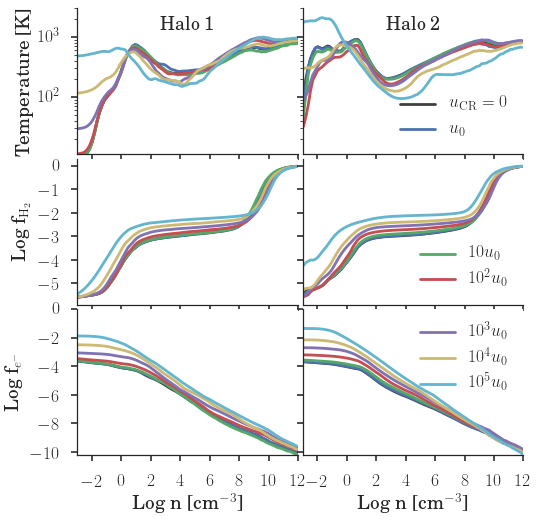

In [12]:
sns.set(context='poster', style='ticks', font='serif', font_scale=1.1)
f,axarr = plt.subplots(3,2, sharex=True, figsize=(8,8))

for i,halo in enumerate(['halo1','halo2']):
    ax = axarr[0][i]
    df = average[halo+'_vanilla']
    ax.semilogy(df.logn, df.temperature, color='.25')#, label=simname['vanilla'])
    for sim in simlist[1:]:
        df = average[halo+'_'+sim]
        ax.semilogy(df.logn, df.temperature)#, label=simname[sim])
    ax.set_xlim(-3., 12.001)
    ax.set_ylim(11,3e3)
    ax.text(.5,.95, 'Halo '+str(i+1), ha='center', va='top', size=18, transform=ax.transAxes)

for i,halo in enumerate(['halo1','halo2']):
    handles = []
    ax = axarr[1][i]
    df = average[halo+'_vanilla']
    handle, = ax.plot(df.logn, df.logh2, color='.25', label=simname['vanilla'])
    handles.append(handle)
    for sim in simlist[1:]:
        df = average[halo+'_'+sim]
        handle, = ax.plot(df.logn, df.logh2, label=simname[sim])
        handles.append(handle)
    ax.set_ylim(-5.9,.3)

for i,halo in enumerate(['halo1','halo2']):
    handles = []
    ax = axarr[2][i]
    df = average[halo+'_vanilla']
    handle, = ax.plot(df.logn, df.loge, color='.25', label=simname['vanilla'])
    handles.append(handle)
    for sim in simlist[1:]:
        df = average[halo+'_'+sim]
        handle, = ax.plot(df.logn, df.loge, label=simname[sim])
        handles.append(handle)
    ax.set_ylim(-10.2,0)
    ax.set_xlabel('Log n [cm$^{-3}$]')

axarr[0,0].set_ylabel(r'Temperature [K]')
axarr[1,0].set_ylabel(r'Log f$_{{\rm H}_2}$')
axarr[2,0].set_ylabel(r'Log f$_{e^-}$ ')
for ax in axarr[:,1]:
    ax.yaxis.set_ticklabels([])
axarr[0,1].legend(loc=4, handles=handles[:2])
axarr[1,1].legend(loc=4, handles=handles[2:4])
axarr[2,1].legend(loc=1, handles=handles[4:])
f.subplots_adjust(hspace=0.03, wspace=0.02)
sns.despine()
f.savefig('figures/phase_diagrams/binned_T_efrac.eps', bbox_inches='tight')

In [13]:
simname = {'vanilla':r'$u_{\rm \tiny CR} = 0$',
        'cr00': r'$u_{\rm \tiny CR} = u_0$', 
        'cr01': r'$u_{\rm \tiny CR} = 10 u_0$', 
        'cr02': r'$u_{\rm \tiny CR} = 10^2 u_0$', 
        'cr03': r'$u_{\rm \tiny CR} = 10^3 u_0$', 
        'cr04': r'$u_{\rm \tiny CR} = 10^4 u_0$',
        'cr05': r'$u_{\rm \tiny CR} = 10^5 u_0$'}

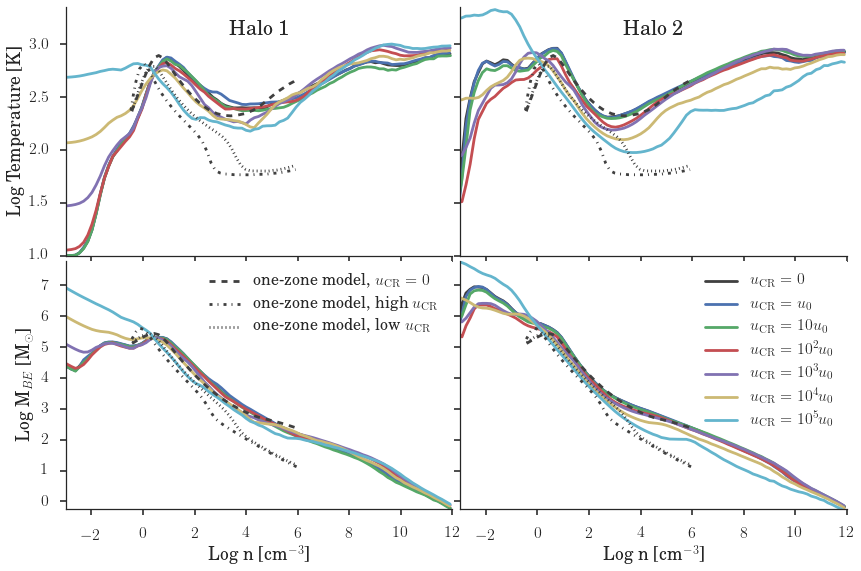

In [16]:
sns.set(context='poster', style='ticks', font='serif', font_scale=1.)
f,axarr = plt.subplots(2,2, sharex=True, figsize=(14,9))

for i,halo in enumerate(['halo1','halo2']):
    ax = axarr[0][i]
    df = average[halo+'_vanilla']
    ax.plot(df.logn, df.logT, color='.25')#, label=simname['vanilla'])
    for sim in simlist[1:]:
        df = average[halo+'_'+sim]
        ax.plot(df.logn, df.logT)#, label=simname[sim])
    oneZ1, = ax.plot(ars_temp.logn, ars_temp.logT, color='.25', ls='--', 
                     label=r"one-zone model, $u_{\rm \tiny CR} = 0$")
    oneZ2, = ax.plot(ars_temp_hiSF.logn, ars_temp_hiSF.logT, color='.25', ls='-.', 
                     label=r"one-zone model, high $u_{\rm \tiny CR}$")
    oneZ3, = ax.plot(ars_temp_loSF.logn, ars_temp_loSF.logT, color='.25', ls=':', 
                     label=r"one-zone model, low $u_{\rm \tiny CR}$")
    ax.set_xlim(-3., 12.001)
    ax.set_ylim(1.,3.35)
    ax.text(.5,.95, 'Halo '+str(i+1), ha='center', va='top', size=20, transform=ax.transAxes)

for i,halo in enumerate(['halo1','halo2']):
    handles = []
    ax = axarr[1][i]
    df = average[halo+'_vanilla']
    handle, = ax.plot(df.logn, df.logM, color='.25', label=simname['vanilla'])
    handles.append(handle)
    for sim in simlist[1:]:
        df = average[halo+'_'+sim]
        handle, = ax.plot(df.logn, df.logM, label=simname[sim])
        handles.append(handle)
    ax.plot(ars_mbe.logn, ars_mbe.logM, color='.25', ls='--')#, label="one-zone model")
    ax.plot(ars_mbe_hiSF.logn, ars_mbe_hiSF.logM, color='.25', ls='-.')#, label="one-zone, high SF")
    ax.plot(ars_mbe_loSF.logn, ars_mbe_loSF.logM, color='.25', ls=':')#, label="one-zone, low SF")
    ax.set_ylim(-.25,7.8)
    ax.set_xlabel('Log n [cm$^{-3}$]')

axarr[0,0].set_ylabel('Log Temperature [K]')
axarr[1,0].set_ylabel('Log M$_{BE}$ [M$_{\odot}$]')
for ax in axarr[:,1]:
    ax.yaxis.set_ticklabels([])
axarr[1,0].legend(loc=0, handles=[oneZ1,oneZ2,oneZ3])
axarr[1,1].legend(loc=0, handles=handles)
f.subplots_adjust(hspace=0.02, wspace=0.02)
sns.despine()
f.savefig('figures/phase_diagrams/binned_T_Mbe.eps', bbox_inches='tight')